* Carga el video utilizando cv2.VideoCapture.
* Extrae los frames del video uno por uno.
* Preprocesa cada frame para que sean compatibles con el modelo de PyTorch (tamaño, normalización, etc.).
* Usa un modelo preentrenado de PyTorch (como ResNet) para extraer características de cada frame.
* Aplica un algoritmo de clustering (como K-Means) a las características extraídas.
* Asigna cada frame al cluster correspondiente.
* Visualiza los resultados mostrando los frames y su cluster correspondiente.

In [2]:
import cv2
import torch
import numpy as np
from torchvision import models, transforms
from sklearn.cluster import AgglomerativeClustering,DBSCAN
import matplotlib.pyplot as plt
from torchsummary import summary
import warnings
warnings.filterwarnings('ignore')

if torch.cuda.is_available():
 dev = "cuda:0"
else:
 dev = "cpu"

device = torch.device(dev)

# Inicializa el modelo preentrenado de PyTorch
model = models.resnet18(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])
model = model.to(device)
#summary(model,(3,224,224))
model.eval()

# Transformaciones para los frames del video
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(120),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#TODO  imprimir preview de imagenes.


# Leer video
video_path = 'video.mp4'
cap = cv2.VideoCapture(video_path)

# Extraer características de los frames del video
features = []

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocesa el frame
    input_tensor = preprocess(frame)
    input_batch = input_tensor.unsqueeze(0).to(device)


    #print("input",input_tensor.shape)
    #plt.imshow(cv2.cvtColor(input_tensor.numpy().transpose(1,2,0), cv2.COLOR_BGR2RGB))
    #plt.show()

    # Extrae características
    with torch.no_grad():
        output = model(input_batch)
        #print(output.shape)

    # Convierte las características a un formato compatible con sklearn
    features.append(output.cpu().numpy().flatten())

# Cierra el capturador de video
cap.release()

# Convierte la lista de características a un array de NumPy
features = np.array(features)


In [3]:
# Aplica K-Means clustering
n_clusters = 5  # por ejemplo, 5 clusters

evaluator = AgglomerativeClustering(n_clusters=None, distance_threshold=50)
# evaluator = DBSCAN(eps=20, min_samples=5)
#HDBScan
evaluator.fit(features)
cluster_labels = evaluator.labels_
#print(evaluator.n_clusters_)

In [4]:
# Vuelve a leer el video para visualizar los resultados
from collections import defaultdict

cap = cv2.VideoCapture(video_path)
frame_number = 0
printed_labels = defaultdict(list)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Muestra el frame con la etiqueta del cluster
    label = cluster_labels[frame_number]
    printed_labels[label].append(frame)

    frame_number += 1

# Cierra el capturador de video
cap.release()

{11: 69, 4: 50, 1: 43, 9: 104, 3: 67, 0: 134, 10: 170, 8: 31, 7: 138, 5: 47, 6: 154, 2: 130}


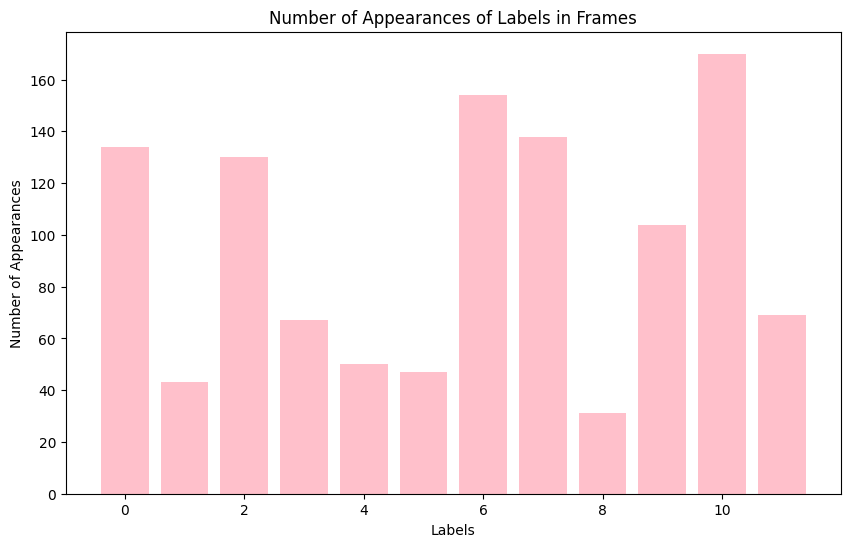

In [5]:

def plot_label_counts(labels_dict):
    """
    Plots a bar chart showing the number of appearances of each label.

    :param labels_dict: A dictionary where keys are labels and values are lists of frames.
    """
    # Counting the number of frames for each label
    label_counts = {label: len(frames) for label, frames in labels_dict.items()}
    print(label_counts)
    # Data for plotting
    labels = list(label_counts.keys())
    counts = list(label_counts.values())

    # Creating the bar chart
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='pink')
    plt.xlabel('Labels')
    plt.ylabel('Number of Appearances')
    plt.title('Number of Appearances of Labels in Frames')
    plt.show()

plot_label_counts(printed_labels)

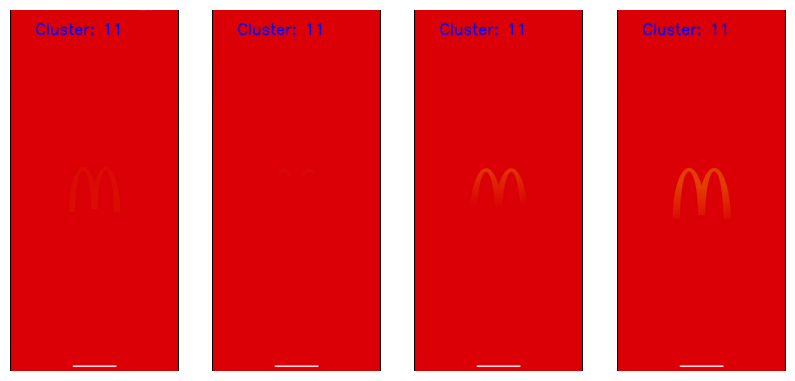

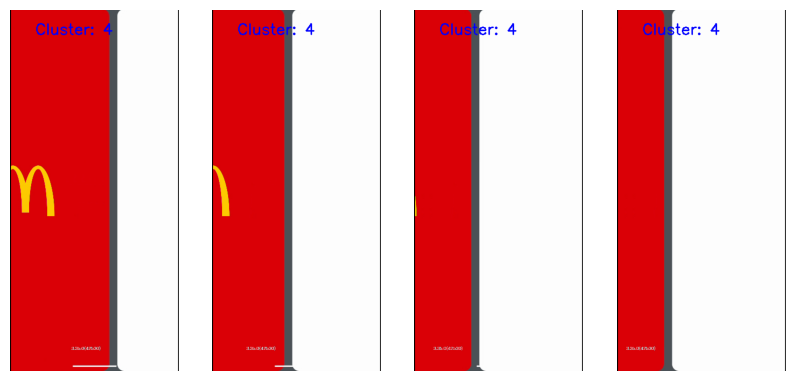

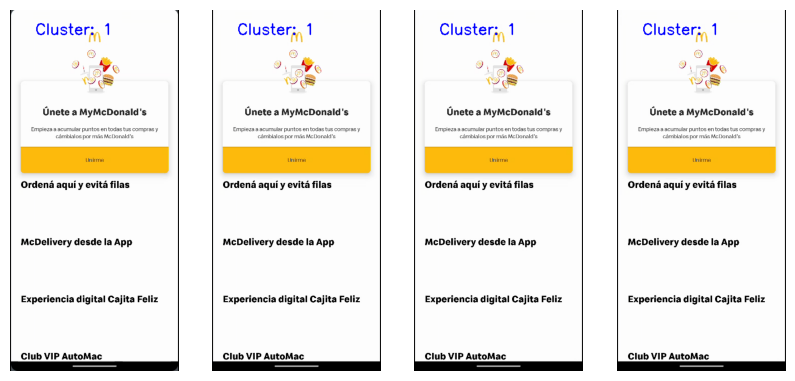

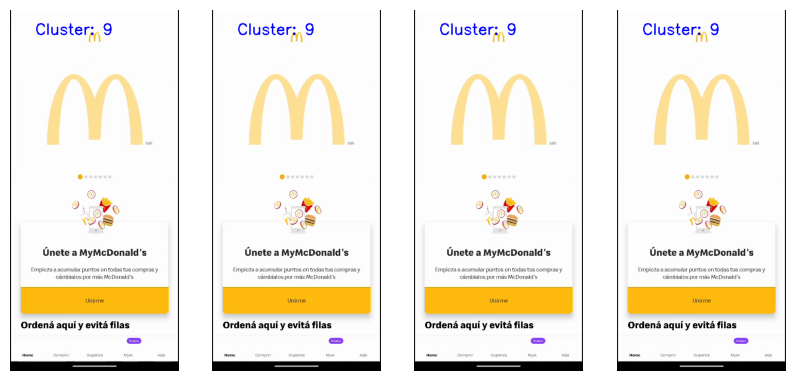

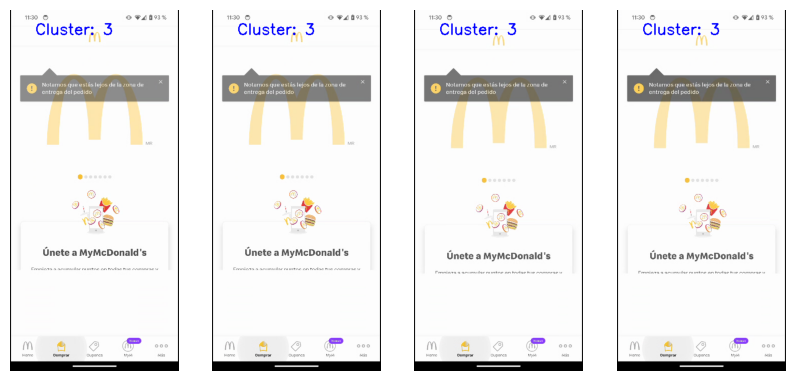

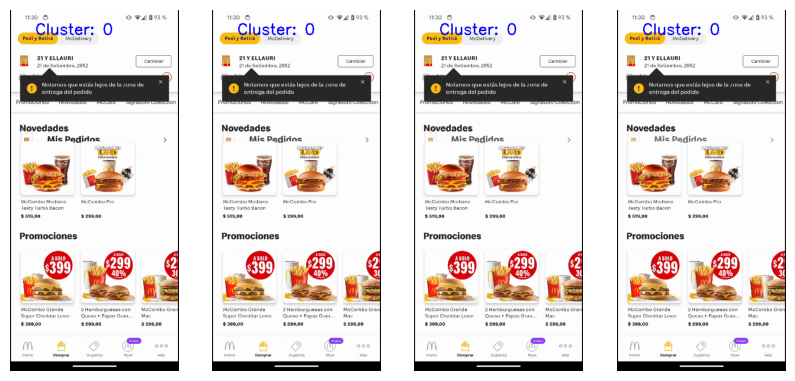

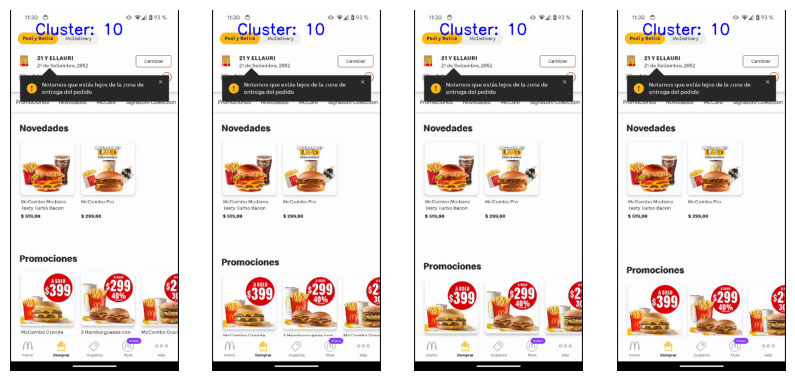

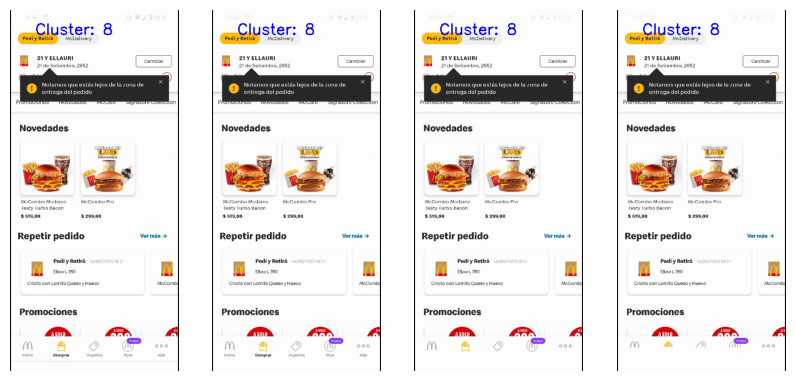

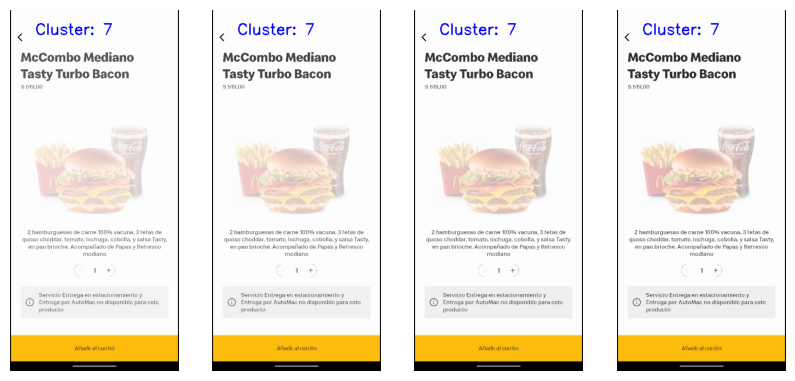

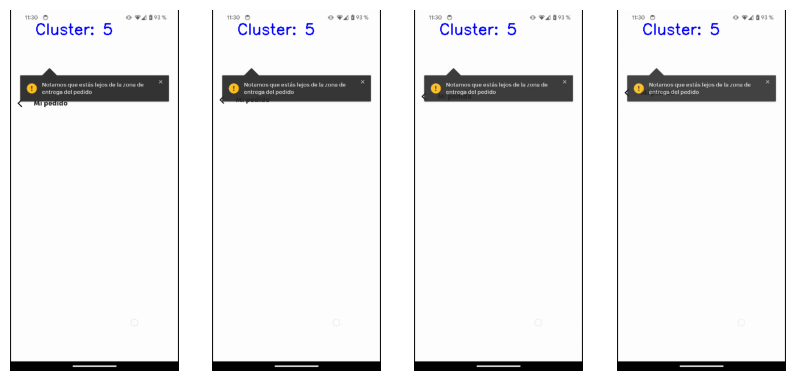

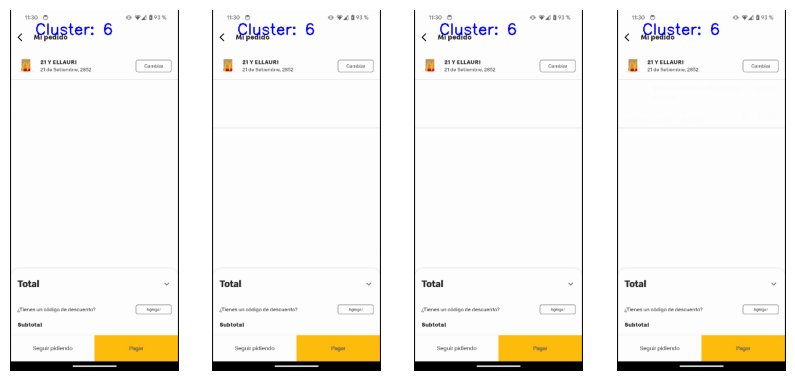

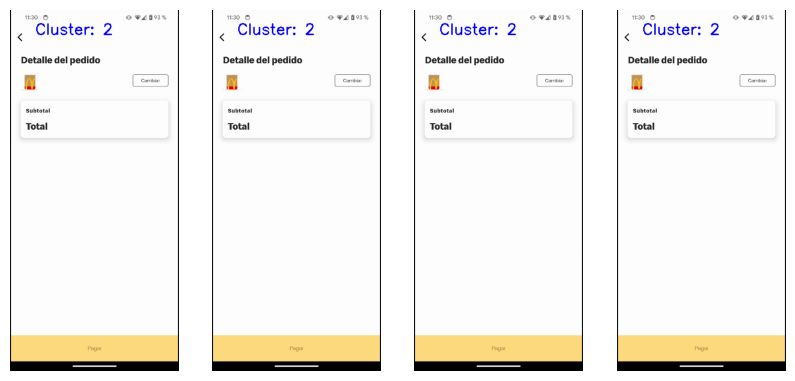

In [6]:
for label, frames in printed_labels.items():
  frames_per_images = len(frames)
  if(len(frames)>4):
    frames_per_image = 4

  plt.figure(figsize=(10, 5))

  for idx, frame in enumerate(frames[:frames_per_image]):
    #TODO Random
    plt.subplot(1, frames_per_image, idx+1)  # 1 fila, 2 columnas, posición 2
    plt.axis('off')
    cv2.putText(frame, f'Cluster: {label}', (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  plt.show()

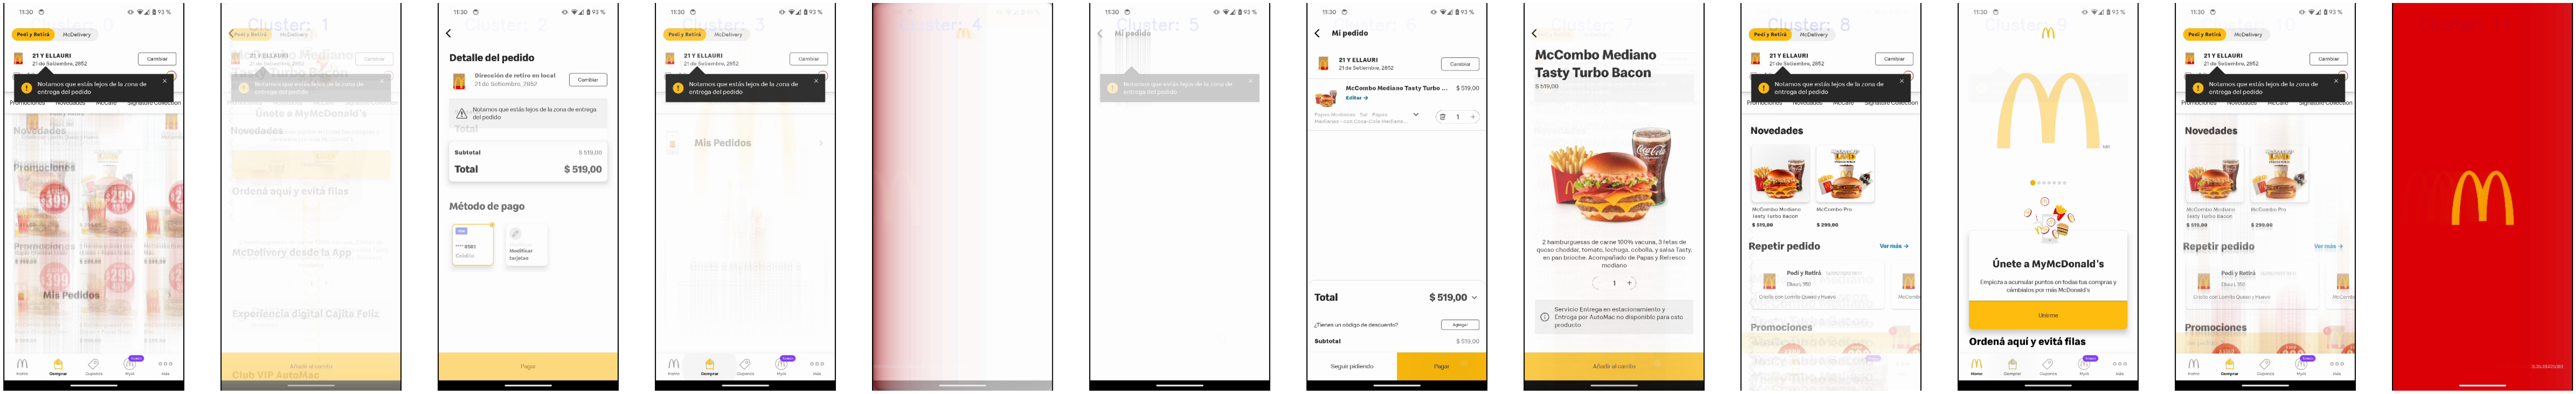

In [7]:
import cv2
import numpy as np

sorted_labels = sorted(printed_labels.keys())

plt.figure(figsize=(100, 100))

for idx, label in enumerate(sorted_labels):

  frames = printed_labels[label]
  plt.subplot(1, len(sorted_labels), idx+ 1)
  plt.axis('off')
  # Calcula la imagen promedio
  # Convierte las imágenes a float para evitar problemas de desbordamiento
  average_frame = np.mean([frame.astype(np.float32) for frame in frames], axis=0)
  average_frame = np.array(np.round(average_frame), dtype=np.uint8)

  # Mostrar la imagen promedio
  plt.imshow(cv2.cvtColor(average_frame, cv2.COLOR_BGR2RGB))
plt.show()

In [8]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from collections import namedtuple

def tag_cluster(cluster_labels, tags,steps):
  tagged_clusters = {}
  for _ in range(steps):
    shuffle_tags=np.random.permutation(tags)
    for start, end, screen, action in shuffle_tags:
      frames = cluster_labels[int(start):int(end)]
      frames = list(filter( lambda x: x not in tagged_clusters.keys(), frames))
      values, counter= np.unique(frames, return_counts=True)
      if(len(counter)>0):
        tagged_clusters[values[np.argmax(counter)]] = screen
  result=[]
  for frames in cluster_labels:
    result.append(tagged_clusters.get(frames,"NO_CLASS"))
  return result


def get_metrics(y_true, y_pred):
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Calcular precisión, recall, F1-score y exactitud
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)

    return conf_matrix, precision, recall, f1, accuracy

def show_metrics(experiment, ceonf_matrix, precision, recall, f1, accuracy):
    print("Experiment name:",experiment)
    #print(f'Matriz de confusión:\n{conf_matrix}')
   # print(f'Precisión: {precision}')
    #print(f'Recall: {recall}')
    print(f'F1-score: {f1}')
    print(f'Accuracy: {accuracy}')

def eval_cluster(cluster_labels, tags,steps):
  y_pred = tag_cluster(cluster_labels, tags,steps)
  return eval(y_pred,tags,steps)

def eval(y_pred, tags,steps):
  y_true = []
  for start, end, screen, action in tags:
    y_true+=(end-start+1)*[screen]
  return get_metrics(y_true,y_pred)


def eval_massive_cluster(cluster_labels, tags,steps,epochs):
  precision_list, recall_list, f1_list, accuracy_list =[],[],[],[]
  for _ in range(epochs):
    _, precision, recall, f1, accuracy = eval_cluster(cluster_labels, tags,steps)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    accuracy_list.append(accuracy)
  return calculate_mean_var(precision_list,recall_list, f1_list, accuracy_list)

def calculate_mean_var(precision_list, recall_list, f1_list, accuracy_list):
    # Crear una namedtuple para los resultados
    MetricsResults = namedtuple('MetricsResults', ['mean', 'std'])

    # Calcular medias y varianzas para cada métrica usando numpy
    precision_results = MetricsResults(np.mean(precision_list), np.std(precision_list))
    recall_results = MetricsResults(np.mean(recall_list), np.std(recall_list))
    f1_results = MetricsResults(np.mean(f1_list), np.std(f1_list))
    accuracy_results = MetricsResults(np.mean(accuracy_list), np.std(accuracy_list))

    # Crear una namedtuple para agrupar los resultados
    OverallResults = namedtuple('OverallResults', ['precision', 'recall', 'f1', 'accuracy'])

    return OverallResults(precision=precision_results, recall=recall_results, f1=f1_results, accuracy=accuracy_results)

def show_metrics_massive(experiment,epochs, overall_results):
    print("Experiment name:",experiment)
    print("Epochs: ",epochs)
    print("Precision - Mean: {:.2f}, std: {:.10f}".format(overall_results.precision.mean, overall_results.precision.std))
    print("Recall - Mean: {:.2f}, std: {:.10f}".format(overall_results.recall.mean, overall_results.recall.std))
    print("F1-Score - Mean: {:.2f}, std: {:.10f}".format(overall_results.f1.mean, overall_results.f1.std))
    print("Accuracy - Mean: {:.2f}, std: {:.10f}".format(overall_results.accuracy.mean, overall_results.accuracy.std))


In [9]:

frames_actions_original = [
   (1, 119, 'Splash screen', 'Idle'),
  (120, 186, 'Home screen', 'Idle'),
  (187, 350, 'Buy action', 'Touch screen'),
  (351, 357, 'Buy screen', 'Idle'),
  (358, 502, 'Buy screen', 'Scrolling'),
  (503, 545, 'Buy screen', 'Idle'),
  (546, 647, 'Product detail screen', 'Touch screen'),
  (648, 692, 'Cart screen', 'Idle'),
  (693, 768, 'Add to cart', 'Touch screen'),
  (769, 791, 'Buy screen', 'Idle'),
  (792, 888, 'View cart', 'Touch screen'),
  (889, 901, 'Cart screen', 'Idle'),
  (902, 1001, 'Pay', 'Touch screen'),
  (1002, 1137, 'Cart details', 'Idle'),
]

frames_actions_custom = [
    (1, 120, 'carga la app',''),
    (121, 200, 'home',''),
    (201, 294, 'clic en comprar loading',''),
    (295, 545, 'lista de productos',''),
    (546, 603, 'hace clic en una hamburguesa y loading',''),
    (604, 692, 'detalle de producto',''),
    (693, 767, 'agregar producto al carro loading',''),
    (768, 792, 'lista de productos',''),
    (793, 854, 'voy al carrito y loading',''),
    (855, 901, 'carrito',''),
    (902, 1009, 'pagar y loading',''),
    (1010, 1137, 'detail of pay',''),
]

epochs = 10
steps=1

show_metrics_massive("Dataset cliente",epochs,eval_massive_cluster(cluster_labels, frames_actions_original,steps,epochs))
print()
show_metrics_massive("Dataset tagueado",epochs,eval_massive_cluster(cluster_labels, frames_actions_custom,steps,epochs))


# print(eval(cluster_labels, frames_actions_original))
# print(eval(cluster_labels, frames_actions_custom))

# Ahora frames_actions es una lista de tuplas, donde cada tupla representa un rango de frames y sus correspondientes acciones.


Experiment name: Dataset cliente
Epochs:  10
Precision - Mean: 0.78, std: 0.0267638416
Recall - Mean: 0.67, std: 0.0359963618
F1-Score - Mean: 0.67, std: 0.0333421143
Accuracy - Mean: 0.67, std: 0.0359963618

Experiment name: Dataset tagueado
Epochs:  10
Precision - Mean: 0.67, std: 0.0675555603
Recall - Mean: 0.67, std: 0.0649719740
F1-Score - Mean: 0.65, std: 0.0667619414
Accuracy - Mean: 0.67, std: 0.0649719740
